In [1]:
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD

import sys
sys.path.append('/scratch/cloned_repositories/keras-unet/')

import keras_unet
from keras_unet.utils import get_augmented
from keras_unet.models import custom_unet

from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

from keras_unet.utils import plot_segm_history
from keras_unet.utils import plot_imgs

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
random_seed = 42

In [3]:
weights_dir = '/scratch/fibro_arrhythm_data/ds210320/weights'

In [4]:
image_filenames = glob.glob("/scratch/fibro_arrhythm_data/ds210320/textures/*.npy")
label_filenames = glob.glob("/scratch/fibro_arrhythm_data/ds210320/labels/*.npy")

image_filenames.sort()
label_filenames.sort()

In [5]:
images = []
labels = []

for image_filename, label_filename in zip(image_filenames, label_filenames):
    image = np.load(image_filename)
    image = np.pad(image, (1, 1), 'constant')  # TODO: check this or avoid this by saving the data differently
    images.append(image)
    
    label = np.load(label_filename)
    label = np.pad(label, (1, 1), 'constant')
    labels.append(label)

images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=np.float32)

images = np.expand_dims(images, axis=-1)
labels = np.expand_dims(labels, axis=-1)

print(images.min(), images.max(), "    ", labels.min(), labels.max())
print(images.shape, "    ", labels.shape)

0.0 1.0      0.0 1.0
(998, 256, 256, 1)      (998, 256, 256, 1)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=random_seed)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.111111, random_state=random_seed) # 0.111111 x 0.9 = 0.1

In [7]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (798, 256, 256, 1)
y_train:  (798, 256, 256, 1)
x_val:  (100, 256, 256, 1)
y_val:  (100, 256, 256, 1)
x_test:  (100, 256, 256, 1)
y_test:  (100, 256, 256, 1)


In [8]:
train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='constant'
    ))

In [9]:
input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       spatial_dropout2d[0][0]          
______________________________________________________________________________________________

In [11]:
model_version = 'custom_unet_v0.0.0.0'
callback_checkpoint = ModelCheckpoint(
    weights_dir + '/weights_' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.h5', 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=False,
)

In [12]:
model.compile(
    #optimizer=Adam(), 
    optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)

In [14]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=x_train.shape[0],
    epochs=25,    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 798 steps, validate on 100 samples
Epoch 1/25
797/798 [============================>.] - ETA: 1s - loss: 0.1332 - iou: 0.0098 - iou_thresholded: 0.2377
Epoch 00001: saving model to /scratch/fibro_arrhythm_data/ds210320/weights/weights_custom_unet_v0.0.0.0/weights.01-0.11.h5
798/798 [==============================] - 1374s 2s/step - loss: 0.1333 - iou: 0.0098 - iou_thresholded: 0.2374 - val_loss: 0.1130 - val_iou: 0.0068 - val_iou_thresholded: 0.3604
Epoch 2/25
797/798 [============================>.] - ETA: 1s - loss: 0.1219 - iou: 0.0097 - iou_thresholded: 0.2489
Epoch 00002: saving model to /scratch/fibro_arrhythm_data/ds210320/weights/weights_custom_unet_v0.0.0.0/weights.02-0.11.h5
798/798 [==============================] - 1379s 2s/step - loss: 0.1218 - iou: 0.0097 - iou_thresholded: 0.2486 - val_loss: 0.1128 - val_iou: 0.0080 - val_iou_thresholded: 0.3604
Epoch 3/25
797/7

Epoch 20/25
797/798 [============================>.] - ETA: 1s - loss: 0.1221 - iou: 0.0094 - iou_thresholded: 0.2477
Epoch 00020: saving model to /scratch/fibro_arrhythm_data/ds210320/weights/weights_custom_unet_v0.0.0.0/weights.20-0.11.h5
798/798 [==============================] - 1389s 2s/step - loss: 0.1220 - iou: 0.0094 - iou_thresholded: 0.2487 - val_loss: 0.1129 - val_iou: 0.0080 - val_iou_thresholded: 0.3604
Epoch 21/25
797/798 [============================>.] - ETA: 1s - loss: 0.1216 - iou: 0.0097 - iou_thresholded: 0.2439
Epoch 00021: saving model to /scratch/fibro_arrhythm_data/ds210320/weights/weights_custom_unet_v0.0.0.0/weights.21-0.11.h5
798/798 [==============================] - 1392s 2s/step - loss: 0.1217 - iou: 0.0098 - iou_thresholded: 0.2436 - val_loss: 0.1126 - val_iou: 0.0076 - val_iou_thresholded: 0.3604
Epoch 22/25
797/798 [============================>.] - ETA: 1s - loss: 0.1217 - iou: 0.0096 - iou_thresholded: 0.2602
Epoch 00022: saving model to /scratch/fibr

In [15]:
model.save(weights_dir + '/' + model_version + '.h5')

In [17]:
history.history

{'loss': [0.13327435434231052,
  0.12184221582267817,
  0.12190861009845608,
  0.12177900208585095,
  0.12187888538161465,
  0.12159942866380054,
  0.12177242764171428,
  0.12178284351137422,
  0.12185094474037562,
  0.12176263033596794,
  0.1215988488162968,
  0.121726747119057,
  0.1217030380598099,
  0.1218805238231083,
  0.12164631396074567,
  0.12194045215499655,
  0.12167398946448452,
  0.12210280027819381,
  0.12187822718163929,
  0.12199798973048465,
  0.12168801943526457,
  0.12173870357365013,
  0.12174584602418922,
  0.12170919869095087,
  0.12171520765422654],
 'iou': [0.009781266,
  0.00968866,
  0.009655013,
  0.009795161,
  0.009594747,
  0.0098049585,
  0.009616702,
  0.009815711,
  0.009783105,
  0.009766829,
  0.009805839,
  0.009633576,
  0.00976261,
  0.009554162,
  0.009898515,
  0.009877381,
  0.009338616,
  0.010017688,
  0.00978296,
  0.009390662,
  0.009752047,
  0.00964955,
  0.009660509,
  0.009716892,
  0.009619465],
 'iou_thresholded': [0.23740557,
  0.2486

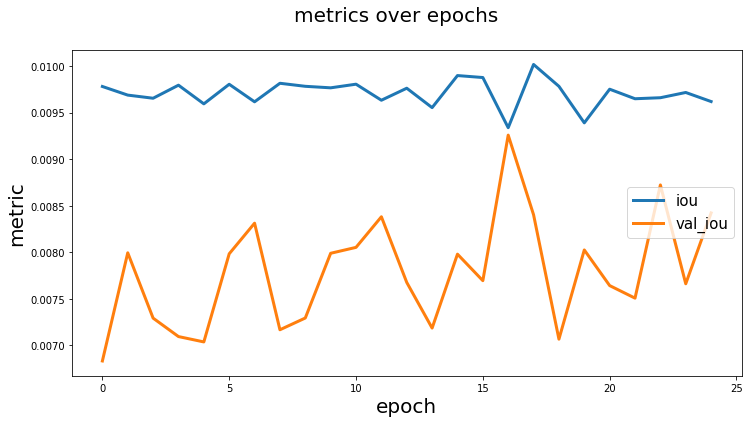

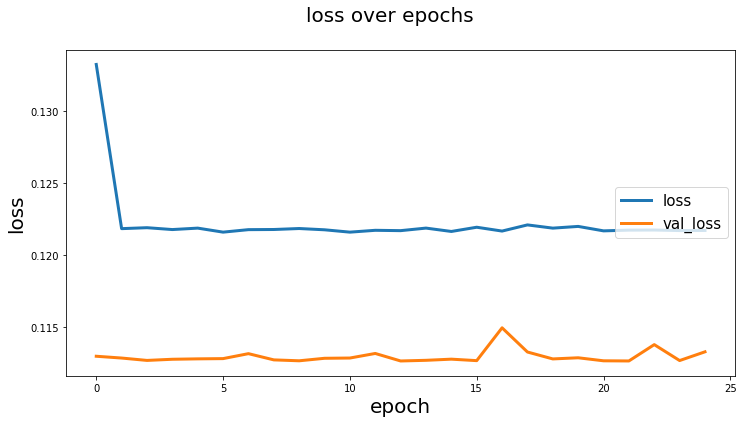

In [18]:
plot_segm_history(history)

In [13]:
model.load_weights(weights_dir + '/' + model_version + '.h5')

In [14]:
x_test.shape

(100, 256, 256, 1)

In [15]:
y_pred = model.predict(x_test[10:30])

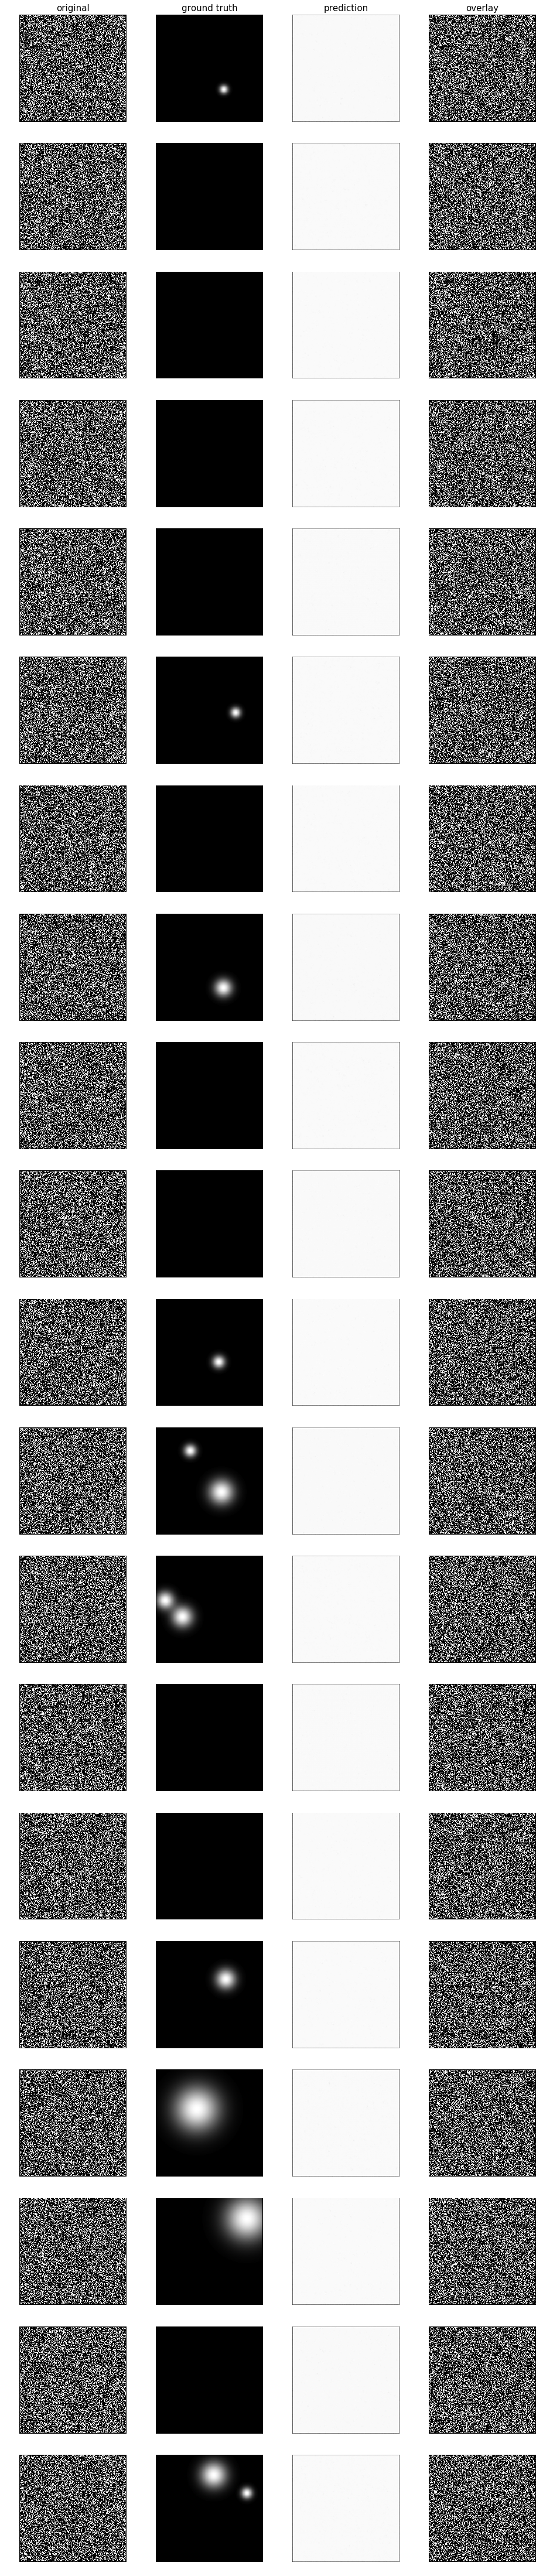

In [16]:
plot_imgs(org_imgs=x_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=20)

In [27]:
temp = y_pred[5,:,:,0]

In [29]:
np.max(temp)

0.029803006